# Simple regression

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results, plot_rhats
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

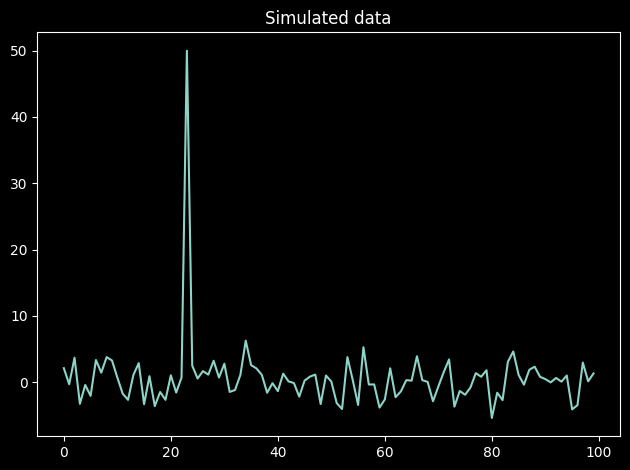

In [3]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.9]),
    sigsq0 = jnp.array(2.0))
y = y.at[23].set(50.0)

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [4]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [5]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

GHMC alpha: 0.5978, delta: 0.2989, step size: 0.4532


In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.927,0.471,0.049,1.823,0.002,0.002,42010.0,68700.0,1.0
beta[1],0.373,0.451,-0.468,1.229,0.002,0.001,65622.0,102149.0,1.0
beta[2],1.115,0.402,0.363,1.873,0.002,0.001,69397.0,106969.0,1.0
beta[3],1.130,0.447,0.289,1.970,0.002,0.001,46452.0,75951.0,1.0
sigsq,20.014,2.162,16.079,24.115,0.009,0.006,60342.0,94339.0,1.0


In [7]:
print(f"Saw {state.divergences.sum()} divergences")

Saw 0.0 divergences


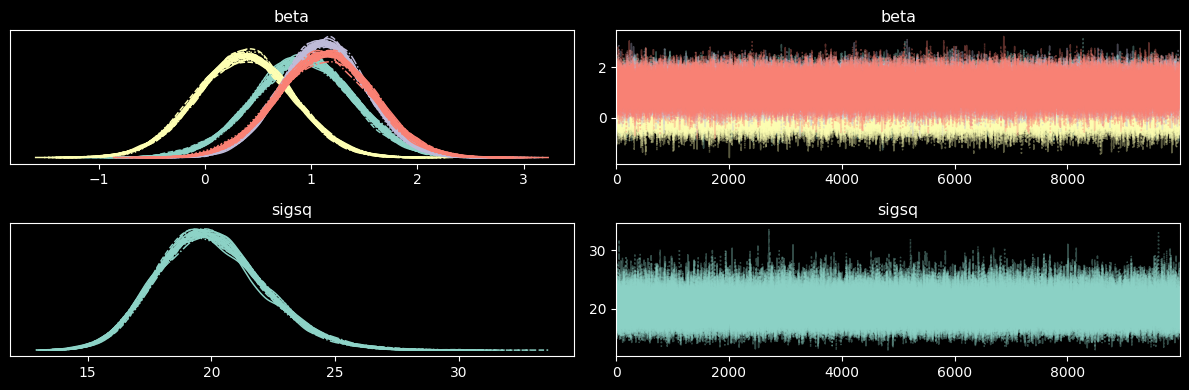

In [8]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [9]:
warmup_results = simple_cv_adaptation(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    warmup_model_id=0,
    num_chains=16,
    adaptation_iter=1_000,
    burnin_iter=500,
    batch_size=100,
)

MEADS warmup for 2 model(s) (32 chains)...
Meads warmup done in 4.15 seconds. 
Step size: 0.5600 Alpha: 0.6772 Delta: 0.3386
Approximated 20 modes in 0 min 0.8 sec
Burn-in for 320 chains run took 0 min 5.5 sec


In [10]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(1),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup_results,
       batch_size=100,
       max_batches=51,
       ignore_stoprule=True,
       prior_only=False
)
print('done')

Starting cross-validation with 320 parallel GHMC chains...
   0.  Model A: -756.40 ±488.88 ess 61926, Model B: -636.86 ±366.61 ess 63672
       Diff: -119.53 ±122.28, Rhat < 1.0025  stop
       Triggered stoprule after 1 batches in 4 seconds
  10.  Model A: -683.33 ±429.85 ess 142719, Model B: -593.26 ±337.15 ess 144834
       Diff: -90.07 ±92.72, Rhat < 1.0016  stop
  20.  Model A: -682.36 ±430.50 ess 201316, Model B: -592.28 ±337.80 ess 202291
       Diff: -90.08 ±92.71, Rhat < 1.0009  stop
  30.  Model A: -682.09 ±430.89 ess 254301, Model B: -589.35 ±335.51 ess 250042
       Diff: -92.75 ±95.39, Rhat < 1.0007  stop
  40.  Model A: -669.93 ±419.05 ess 296250, Model B: -589.29 ±335.79 ess 295601
       Diff: -80.64 ±83.27, Rhat < 1.0008  stop
  50.  Model A: -669.94 ±419.27 ess 341028, Model B: -569.14 ±315.84 ess 343128
       Diff: -100.80 ±103.44, Rhat < 1.0006  stop
Drew 1632000 samples in 1 min 48 sec (15084 per sec)
done


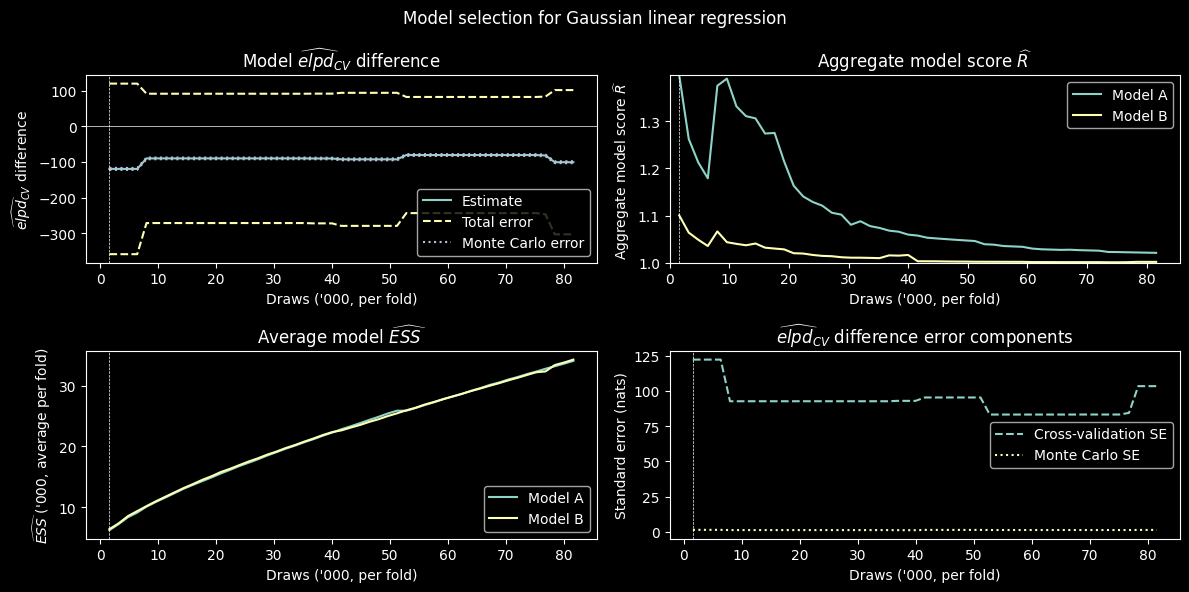

In [11]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

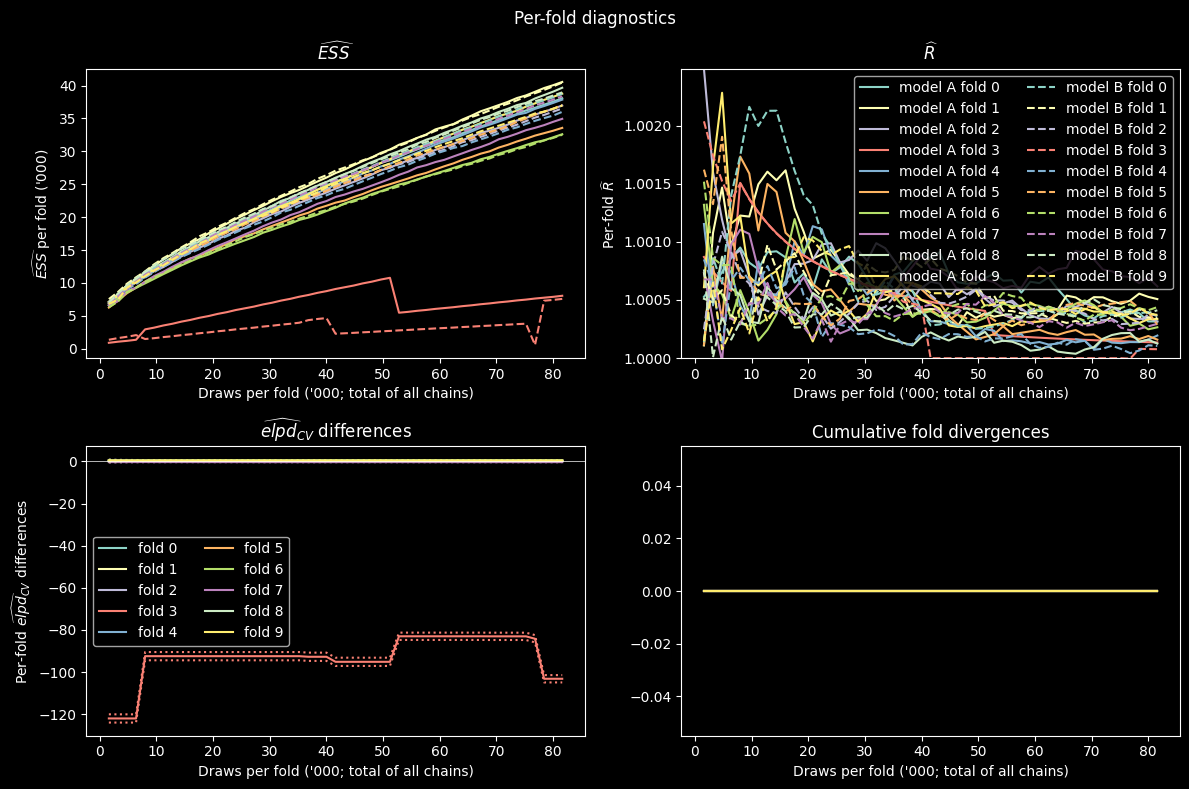

In [12]:
plot_fold_results(results, title='Per-fold diagnostics')

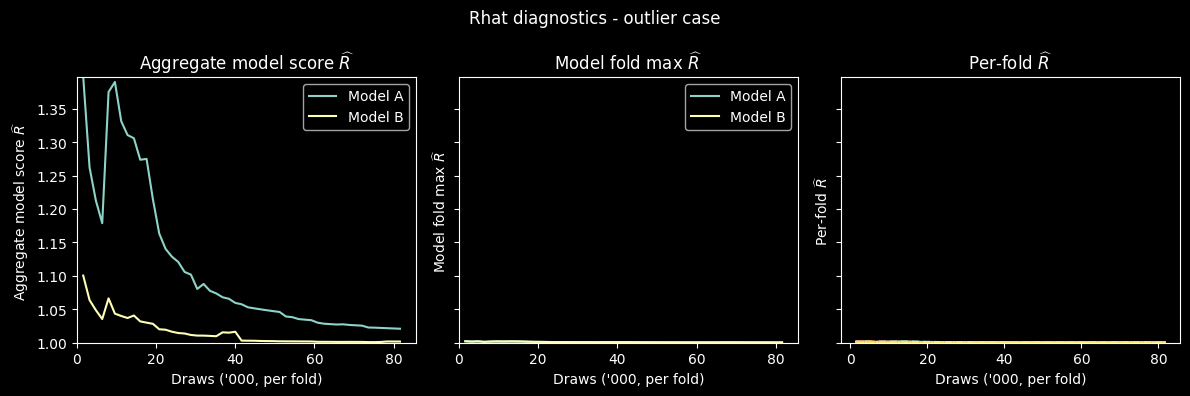

In [14]:
plot_rhats(results, title='Rhat diagnostics - outlier case')